In [339]:
import numpy as np
import pickle as pkl
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [340]:
"""
This creates a tensor X of shape (L, F) per object, where:
F = 6 right now: [g, r, g_err, r_err, g_mask, r_mask]
masks are 1 if observed/interpolated, 0 if missing
"""
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

def make_time_grid(t_all, T=200.0, L=128):
    # relative time grid from 0..T
    t0 = np.min(t_all) # reference time
    grid = np.linspace(0.0, T, L) # time grid
    return t0, grid


def interp_with_mask(t, y, e, t0, grid):
    # """
    # Interpolate y (and e if given) onto grid in relative-time coordinates.
    # Returns (y_grid, e_grid, mask_grid).
    # Mask is 1 where interpolation is valid within data range, else 0.
    # """
    if len(t) == 0:
        y_grid = np.zeros_like(grid) # (L,)
        e_grid = np.ones_like(grid) # (L,)
        mask = np.zeros_like(grid) # (L,)
        return y_grid, e_grid, mask

    dt = t - t0 # relative times
    # sort by time
    order = np.argsort(dt)
    dt = dt[order]
    y = y[order]
    e = e[order] if e is not None else None

    # valid only inside [dt.min, dt.max]
    mask = ((grid >= dt.min()) & (grid <= dt.max())).astype(np.float32)

    # interpolate; outside range we'll still get values, but mask=0 will tell model to ignore
    y_grid = np.interp(grid, dt, y).astype(np.float32)

    if e is None:
        e_grid = np.ones_like(grid, dtype=np.float32)
    else:
        e_grid = np.interp(grid, dt, e).astype(np.float32)

    return y_grid, e_grid, mask

def log_flux_transform(f, scale=1.0):
    # """
    # Sign-safe log1p transform:
    # sign(f) * log1p(|f|/scale)
    # """
    return np.sign(f) * np.log1p(np.abs(f) / (scale + 1e-8))

class TwoBandLC(Dataset):
    def __init__(self, objects, T=300.0, L=128, use_err=True, normalize_per_object=True, up_to_peak=False):
        self.objects = objects # list of dicts, each with 'g' and 'r' keys for bands
        self.T = float(T) # total time span
        self.L = int(L) # length of time grid
        self.use_err = bool(use_err) # whether to use errors
        self.up_to_peak = bool(up_to_peak) # whether to truncate data up to peak time
        self.normalize_per_object = bool(normalize_per_object) # whether to normalize per object

    def __len__(self):
        return len(self.objects) # number of objects

    def __getitem__(self, idx):
        obj = self.objects[idx] # get object dict

        # extract data for g band
        tg = np.asarray(obj["g"]["t"], dtype=np.float32)
        yg = np.asarray(obj["g"]["y"], dtype=np.float32)
        eg = obj["g"].get("e", None)
        eg = np.asarray(eg, dtype=np.float32) if self.use_err and eg is not None else None

        # extract data for g band
        tr = np.asarray(obj["r"]["t"], dtype=np.float32)
        yr = np.asarray(obj["r"]["y"], dtype=np.float32)
        er = obj["r"].get("e", None)
        er = np.asarray(er, dtype=np.float32) if self.use_err and er is not None else None

                # -------------------------------
        # Optionally truncate light curves up to the peak flux time
        # Define peak time as the time of maximum flux across BOTH bands
        # -------------------------------
        if self.up_to_peak:
            all_flux = []
            all_time = []

            if len(tg):
                all_flux.append(yg)
                all_time.append(tg)

            if len(tr):
                all_flux.append(yr)
                all_time.append(tr)

            if len(all_flux) > 0:
                all_flux = np.concatenate(all_flux)
                all_time = np.concatenate(all_time)

                t_peak = all_time[np.argmax(all_flux)]

                # cut both bands at t_peak (keep points with t <= t_peak)
                g_keep = tg <= t_peak
                r_keep = tr <= t_peak

                tg, yg = tg[g_keep], yg[g_keep]
                if eg is not None:
                    eg = eg[g_keep]

                tr, yr = tr[r_keep], yr[r_keep]
                if er is not None:
                    er = er[r_keep]

        # create common time grid
        t_all = np.concatenate([tg, tr]) if (len(tg) and len(tr)) else (tg if len(tg) else tr)
        t0, grid = make_time_grid(t_all, T=self.T, L=self.L)

        # interpolate both bands onto grid
        g_grid, g_err, g_mask = interp_with_mask(tg, yg, eg, t0, grid)
        r_grid, r_err, r_mask = interp_with_mask(tr, yr, er, t0, grid)

        # per-object robust scale (median of positive observed fluxes across both bands)
        if self.normalize_per_object:
            obs = []
            if len(yg):
                obs.append(yg)
            if len(yr): 
                obs.append(yr)
            obs = np.concatenate(obs) if len(obs) else np.array([1.0], dtype=np.float32)
            pos = obs[obs > 0]
            scale = np.median(pos) if len(pos) else (np.median(np.abs(obs)) + 1e-6)
            scale = float(scale) if np.isfinite(scale) and scale > 0 else 1.0
        else:
            scale = 1.0

        # log-flux transform and scale to reduce dynamic range, feat is for "feature"
        g_feat = log_flux_transform(g_grid, scale=scale).astype(np.float32)
        r_feat = log_flux_transform(r_grid, scale=scale).astype(np.float32)

        # Optionally also scale errors into the same space (roughly)
        if self.use_err:
            g_err_feat = (g_err / (scale + 1e-8)).astype(np.float32)
            r_err_feat = (r_err / (scale + 1e-8)).astype(np.float32)
        else:
            g_err_feat = np.ones_like(g_feat, dtype=np.float32)
            r_err_feat = np.ones_like(r_feat, dtype=np.float32)

        # Features: (L, F)
        X = np.stack([g_feat, r_feat, g_err_feat, r_err_feat, g_mask, r_mask], axis=1).astype(np.float32)

        y = float(obj["label"])  # 0.0 or 1.0
        return torch.from_numpy(X), torch.tensor(y, dtype=torch.float32)

In [341]:
list_of_dicts = pkl.load(open("all_objects_dicts.pkl", "rb")) # Load preprocessed dataset
list_of_dicts = [obj for obj in list_of_dicts if "label" in obj] # Filter out objects without labels
labels = np.array([obj["label"] for obj in list_of_dicts], dtype=np.int64) # Extract labels
n_pos = int((labels == 1).sum()) # Count positive samples (TDEs)
n_neg = int((labels == 0).sum()) # Count negative samples (Ia SNe)
dataset = TwoBandLC(list_of_dicts, T=300.0, L=300, use_err=True, normalize_per_object=True, up_to_peak=True) # Create dataset instance

In [342]:
list_of_dicts

[{'Name': 'ZTF22abfrbnl',
  'g': {'t': array([2459830., 2459831., 2459839., 2459840., 2459841., 2459842.,
          2459843., 2459844., 2459845., 2459846., 2459847., 2459848.,
          2459849., 2459850., 2459852., 2459854., 2459855., 2459856.,
          2459857., 2459858., 2459859., 2459860., 2459861., 2459862.,
          2459863., 2459864., 2459865., 2459866., 2459867., 2459868.,
          2459870., 2459871., 2459872., 2459873., 2459874., 2459875.,
          2459878., 2459879., 2459880., 2459881., 2459882., 2459883.,
          2459884., 2459886., 2459888., 2459890., 2459895., 2459896.,
          2459897., 2459898., 2459899., 2459900., 2459903., 2459904.,
          2459905., 2459907., 2459908.]),
   'y': array([3.06365443e-28, 4.92629363e-28, 3.01245200e-27, 3.27862253e-27,
          3.45913806e-27, 3.64474181e-27, 3.73559357e-27, 3.83542170e-27,
          3.87578775e-27, 3.89547051e-27, 3.83724920e-27, 3.65920456e-27,
          3.57717190e-27, 3.52744562e-27, 3.21662107e-27, 2.88881

In [345]:
seed_list = [0,42,123]#,20260116]
outputs = {}
for seed in seed_list:
    folder_path = "output_models/full_lc/seed{}".format(seed)
    outputs["seed_{}".format(seed)] = pkl.load(open(folder_path + "/model_evals.pkl".format(seed),"rb"))

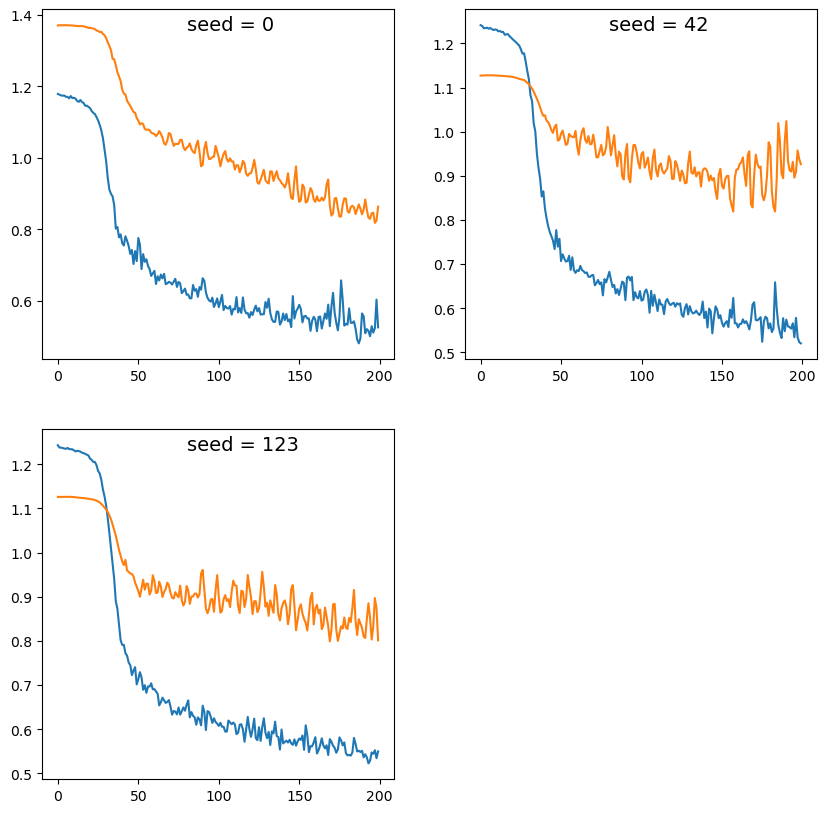

In [346]:
fig = plt.figure(figsize=(10,10))
for ix, seed in enumerate(seed_list):
    output = outputs["seed_{}".format(seed)]
    ax = fig.add_subplot(2,2,ix+1)
    ax.plot(output["train_loss"])
    ax.plot(output["val_loss"])
    ax.text(s='seed = {}'.format(seed),x=len(output["val_loss"])/2.5,y=max(max(output["train_loss"]),max(output["val_loss"]))/1.01,fontsize=14)

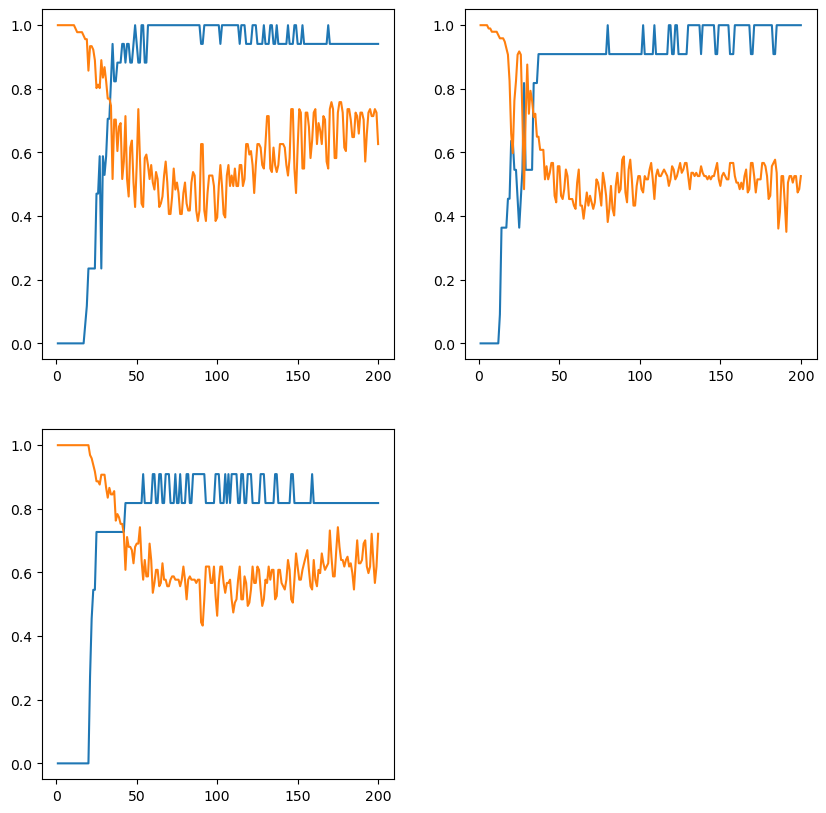

In [347]:
fig = plt.figure(figsize=(10,10))
for ix, seed in enumerate(seed_list):
    ax = fig.add_subplot(2,2,ix+1)
    output = outputs["seed_{}".format(seed)]
    epochs = output['epoch']
    tn = output['tn']
    fp = output['fp']
    fn = output['fn']
    tp = output['tp']

    tpr = tp/(tp+fn)
    tnr = tn/(fp+tn)
    
    ax.plot(epochs,tpr)
    ax.plot(epochs,tnr)

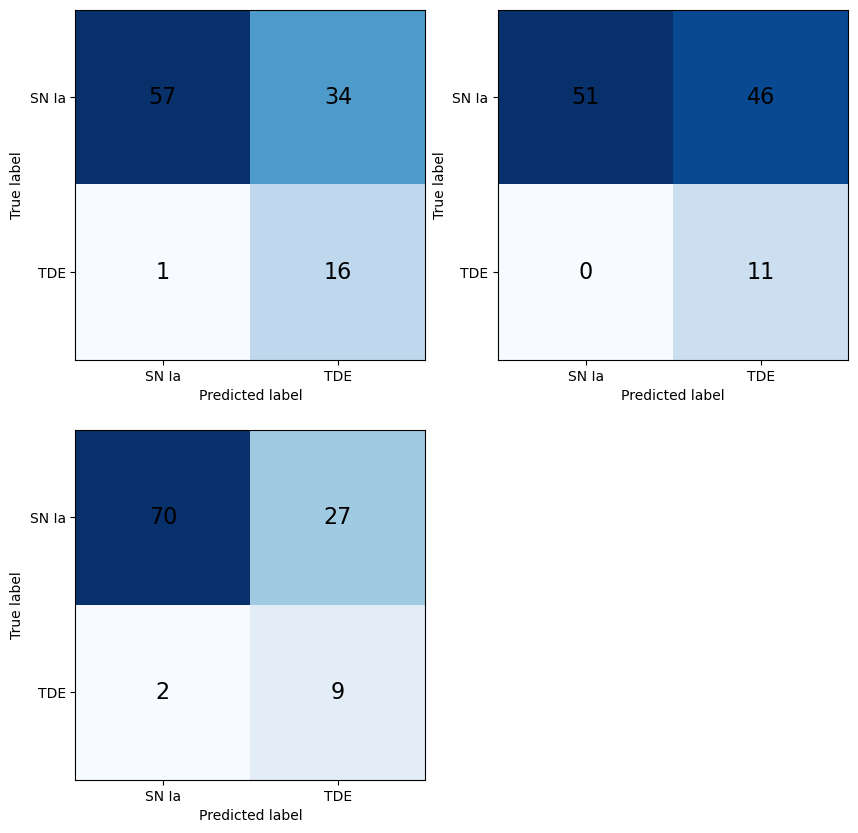

In [348]:
fig = plt.figure(figsize=(10,10))
for ix, seed in enumerate(seed_list):
    output = outputs["seed_{}".format(seed)]
    cm = np.array([
        [output['tn'][-1], output['fp'][-1]],   # [TN, FP]
        [output['fn'][-1],  output['tp'][-1]]    # [FN, TP]
    ])
    ax = fig.add_subplot(2,2,ix+1)
    labels = ["SN Ia", "TDE"]
    im = ax.imshow(cm, cmap="Blues")
    
    # Show values on the cells
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f"{val}", ha="center", va="center", color="black",fontsize=16)
    
    # Axis labels
    ax.set_xticks([0, 1], labels)
    ax.set_yticks([0, 1], labels)
    
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

{'train': <torch.utils.data.dataloader.DataLoader object at 0x14f727710>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x14ead1430>}
[0.9407667  0.9350243  0.8904953  0.9184885  0.93522406 0.9235315
 0.9376328  0.9335491  0.93848145 0.8800335  0.9273811  0.93032163
 0.937836   0.942167   0.92566687 0.93606883 0.93025905]


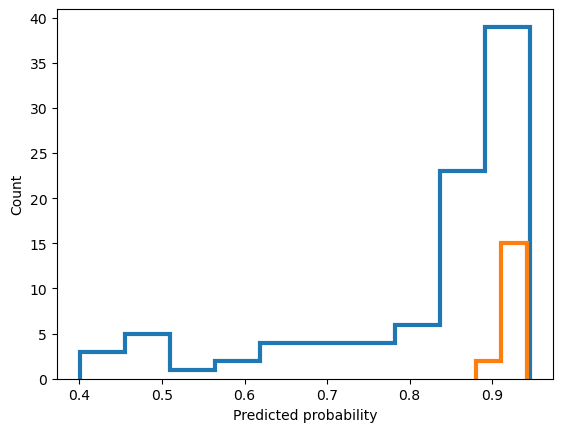

{'train': <torch.utils.data.dataloader.DataLoader object at 0x30f95d3a0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x30fc9bda0>}
[0.99875236 0.99897707 0.99894446 0.9990822  0.99621516 0.99871635
 0.9981185  0.9979087  0.9984263  0.99421126 0.99606484]


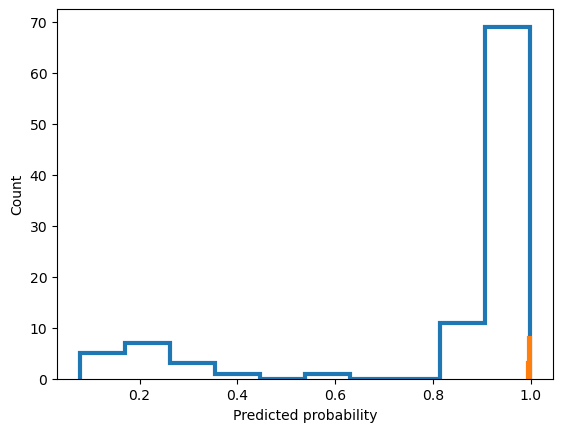

{'train': <torch.utils.data.dataloader.DataLoader object at 0x14f0eed50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x30fad3d10>}
[0.5070887  0.50739425 0.50947803 0.5082793  0.5103027  0.5026934
 0.5093301  0.50948995 0.5058109  0.51049656 0.50898165]


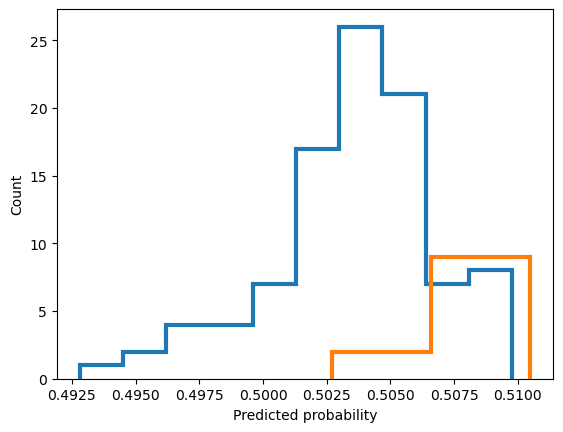

In [338]:
from LSTM_classifier_model import LSTMClassifier

model = LSTMClassifier(
    input_dim=6,
    hidden_dim=64,
    num_layers=2,
    bidirectional=True,
    dropout=0.2
)

seed_list = [0,42,123]#,20260116]
loader_outputs = {}
model_outputs = {}
for seed in seed_list:
    folder_path = "output_models/up_to_peak_lc/seed{}".format(seed)
    loader_output = pkl.load(open(folder_path + "/data_loaders.pkl".format(seed),"rb"))

    state_dict = torch.load(folder_path + "/model.pth", map_location="cpu")
    model.load_state_dict(state_dict)
    model.eval()
    device = "mps"# if torch.mps.is_available() else "mps"
    model.to(device)
    
    print(loader_output)
    for X, y in loader_output['val']:
        X = X.to(device) # move to device
        y = y.to(device) # move to device

        X_Ia = X[y==0]
        X_TDE = X[y==1]
        with torch.no_grad():
            logits_Ia = model(X_Ia)
            probs_Ia = torch.sigmoid(logits_Ia)

            logits_TDE = model(X_TDE)
            probs_TDE = torch.sigmoid(logits_TDE)

        probs_np_Ia = probs_Ia.detach().cpu().numpy()
        probs_np_TDE = probs_TDE.detach().cpu().numpy()
        print(probs_np_TDE)

    plt.hist(probs_np_Ia, bins=10, density=False, cumulative=False, histtype='step', linewidth=3)
    plt.hist(probs_np_TDE, bins=2, density=False, cumulative=False, histtype='step', linewidth=3)
    plt.xlabel("Predicted probability")
    plt.ylabel("Count")
    plt.show()

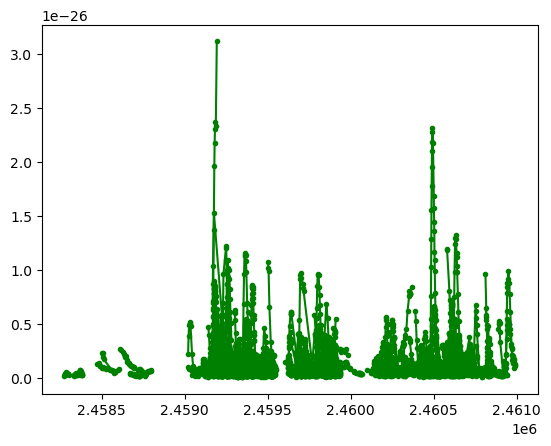

In [276]:
for obj in dataset.objects:
    tg = obj['g']['t']
    yg = obj['g']['y']
    plt.plot(tg,yg,color='g',marker='.')

In [269]:
np.sign(1e-21) * np.log1p(np.abs(1e-21) / (1. + 1e-10))

9.999999999e-22

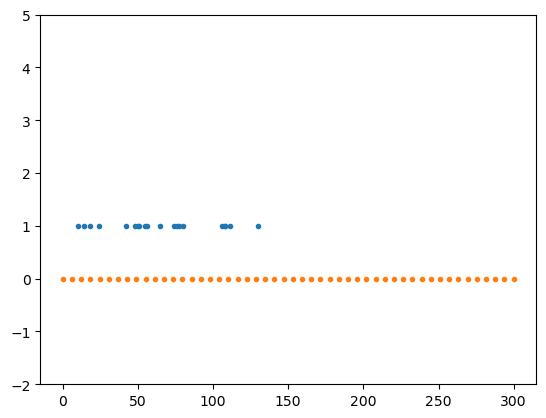

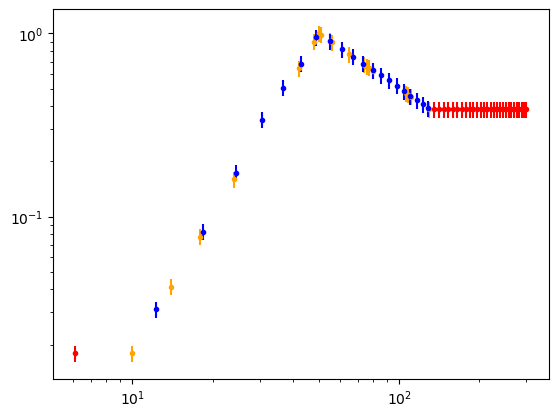

In [36]:
def make_time_grid(t_all, T=200.0, L=128):
    # relative time grid from 0..T
    t0 = np.min(t_all) # reference time
    grid = np.linspace(0.0, T, L) # time grid
    return t0, grid


def interp_with_mask(t, y, e, t0, grid):
    # """
    # Interpolate y (and e if given) onto grid in relative-time coordinates.
    # Returns (y_grid, e_grid, mask_grid).
    # Mask is 1 where interpolation is valid within data range, else 0.
    # """
    if len(t) == 0:
        y_grid = np.zeros_like(grid) # (L,)
        e_grid = np.ones_like(grid) # (L,)
        mask = np.zeros_like(grid) # (L,)
        return y_grid, e_grid, mask

    dt = t# - t0 # relative times
    # sort by time
    order = np.argsort(dt)
    dt = dt[order]
    y = y[order]
    e = e[order] if e is not None else None

    # valid only inside [dt.min, dt.max]
    mask = ((grid >= dt.min()) & (grid <= dt.max())).astype(np.float32)

    # interpolate; outside range we'll still get values, but mask=0 will tell model to ignore
    y_grid = np.interp(grid, dt, y).astype(np.float32)

    if e is None:
        e_grid = np.ones_like(grid, dtype=np.float32)
    else:
        e_grid = np.interp(grid, dt, e).astype(np.float32)

    return y_grid, e_grid, mask


time_vec = np.random.randint(3.5, 145.8, size=20)
order = np.argsort(time_vec)
time_vec = time_vec[order]

y = []
for t in time_vec:
    if t < 50:
        y.append((t/50.)**(5./2.))
    else:
        y.append((t/50.)**(-1.))
y = np.array(y)
e = 0.1*y

t0, grid = make_time_grid(time_vec, T=300.0, L=50)
plt.figure()
plt.plot(time_vec,np.ones(len(time_vec)),'.')
plt.plot(grid,np.zeros(len(grid)),'.')

plt.ylim(-2,5)

y_grid, e_grid, mask = interp_with_mask(time_vec, y, e, t0, grid)
plt.figure()
plt.errorbar(time_vec,y,e,linestyle='none',marker='.',color='orange')
for grid1,y_grid1,e_grid1, mask1 in zip(grid,y_grid,e_grid, mask):
    if mask1:
        plt.errorbar(grid1,y_grid1,e_grid1,linestyle='none',marker='.',color='blue')
    else:
        plt.errorbar(grid1,y_grid1,e_grid1,linestyle='none',marker='.',color='red')
plt.xscale('log')
plt.yscale('log')